![](jupyter_images/music_image.jpeg)

# Introduction
Des milliers de chansons voient le jour tous les ans dans le monde. Certaines connaissent de vrais succès dans l’industrie musicale ; d’autres le sont moins. Il est un fait que réussir dans cette industrie demeure une tâche difficile. Investir dans la production d’une chanson requiert des activités diversifiées et peuvent consommer beaucoup de ressources. Il n’y a aucun outil jusque-là automatique dont les artistes et producteurs pourraient s'en servir pour évaluer si leur chanson qu’ils sont sur le point de publier va se révéler 'hit’.

Dans cet article, on cherchera à comprendre ce qui caractérise une chanson populaire, et plus précisement si l'on pourrait prédire la popularité d'une chanson seulement en nous basant sur ses caractéristiques d'audio et celles de l'artiste. Nous allons construire un modèle-classeur de machine learning pouvant classer une chanson en hit ou non-hit. Bien que des facteurs sociaux comme le contexte dans lequel la chanson a été diffusée, la démographie de ses auditeurs et l'effectivité de sa campagne de marketing peuvent tout aussi bien jouer un rôle important dans sa viralité, nous emettons l'hypothèse que les caractéristiques inhérentes à une chanson, tels que l'artiste qui l'interprète, sa duréee, ses caractéristiques d'audio peuvent être correlés et également révélateur de sa viralité.


# Objectif et pipeline

Dans cet article de deux parties, nous allons construire un modèle de machine learning comme un classeur de chansons en hits et non-hits. Pour réussir un tel travail, plus nous avons de données, mieux c'est. Etant donné qu’on n'a pas pu trouver un dataset venant d’une seule et unique source avec toutes les variables, il nous a fallu recourir au data enrichment à mesure que cela ait été nécessaire. Nous avons eu besoin de trois sources pour construire notre jeu de données. Et  l'opération de recueillement s'est déroulée de la manière suivante :
-	<u> Billboard </u> : On s'est servi de la page Wikipédia de [Bilboard Year-End Hot 100](https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_2019) pour recueillir les musiques les plus populaires (hits) pour les années allant de 2010 à 2019. On a utilisé le web scrapping pour accomplir cette tâche.


-   <u> Spotify </u>: Ensuite on a utilisé la librairie [Spotipy](https://spotipy.readthedocs.io/en/2.12.0/) pour récupérer les caractéristiques relatives à l’audio tels que la dansabilité, la vivacité, l'instrumentalité, etc. et à l’artiste comme la popularité, le nombre de followers etc. à la fois des chansons hits provenant du Billboard Year-End Hot 100 et d'autres chansons non-hits sur la période.


-	<u> LyricsOnDemand </u>: Enfin [Genius](https://genius.com/) sera utilisé principalement pour récupérer les paroles des chansons.

On considère qu’une musique de notre dataset est hit si elle a fait partie du classement du Billboard Year-End Hot 100 au moins une fois pendant l’une des années sur la période considérée. En d'autres termes, notre modèle aura pour mission de prédire si une chanson fera partie de la liste des 100 musiques les plus populaires de Bilboard ou non.


##### Outils:
- Le package Spotipy pour accéder aux données de la plateforme musicale de Spotify
- Seaborn et matplotlib pour la visualisation des données
- Pandas et numpy pour l'analyse des données
- Le framework LightGBM et la librarie scikit-learn pour la construction et l'évaluation du modèle 



# Construction du jeu de données

![](jupyter_images/classeur_partie_1_pipeline_.jpg)

Avant de commencer le scrapping, il faut rappeler que j'utilise la version 3.8.2 de Python et via [pip](https://pypi.org/project/pip/), tous les packages nécessaires au projet sont déjà installés.

Comme mentionné dans le workflow, la première étape sera de scrapper le site web de [Billboard Year-End Hot 100](https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_2019). La première chose à faire pour réussir cette tâche est d'importer les packages suivants :

In [47]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

En inspectant la *table* à scraper à partir de la console du developeur, on remarquera qu'elle est de classe *wikitable sortable jquery-tablesorter*. A présent nous pouvons recueillir les chansons pour une année et répéter le processus jusqu'à la dernière. Ainsi, nous executons les lignes de code suivants :

In [48]:
info_array=[]
for i in range(2010,2020,1):
    url='https://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_'+str(i)
    res = requests.get(url).text
    soup=bs(res,'html.parser')

    table = soup.find("table", class_= 'wikitable sortable')
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')

    for row in rows:
        try:
            cols = row.find_all('td')
            cols = [element.text.strip() for element in cols]
            info_array.append([ cols[0].replace('"', ''), cols[1]])
        except:
            pass


Ensuite nous convertissons cet *array* en une *dataframe* et visualize les cinq premières observations.

In [49]:
df1 = pd.DataFrame(info_array)
df1.columns=["track_name", "artists_name"]
df1.head()

,track_name,artists_name
0,Tik Tok,Kesha
1,Need You Now,Lady Antebellum
2,"Hey, Soul Sister",Train
3,California Gurls,Katy Perry featuring Snoop Dogg
4,OMG,Usher featuring will.i.am


1 000 chansons ont été recupérées. Mais étant donné qu'il est possible qu'une chanson fasse partie de la liste pendant plusieurs années, il nous faudra donc enlever les possibles duplications.

In [50]:
df1 = df1.drop_duplicates()
df1.shape

(905, 2)

Il est a noter que certains noms d'artiste contienent le mot *featuring*, attestant généralement que la chanson est un produit issu d'une collaboration entre deux artistes de groupes differents. Nous allons créer une nouvelle variable *dummy* prenant la valeur de 1 si la chanson est issue d'une collaboaration, i.e si le mot *featuring* est présent dans la colonne artists_name, et 0 sinon. Nous profiterons de l'occasion pour stocker le nom de l'artiste principale de la chanson dans la variable *artist_name* que l'on aura créée.

In [51]:
def featuring_(row):
    if 'featuring' in row['artists_name']:
        val = 1
    else: 
        val = 0
    return val

def artist_name_(row):
    if 'feat' in row['artists_name']:
        val=row['artists_name'].split("featuring")[0]
    else: 
        val = row['artists_name']
    return val

df1['featuring'] = df1.apply(featuring_, axis=1)
df1['artist_name'] = df1.apply(artist_name_, axis=1)

df1.head()

,track_name,artists_name,featuring,artist_name
0,Tik Tok,Kesha,0,Kesha
1,Need You Now,Lady Antebellum,0,Lady Antebellum
2,"Hey, Soul Sister",Train,0,Train
3,California Gurls,Katy Perry featuring Snoop Dogg,1,Katy Perry
4,OMG,Usher featuring will.i.am,1,Usher


### *Data enrichment* via Spotify

Nous venons de collecter toutes les chansons hits de la période. La prochaine étape est d'enrichir notre jeu de données avec plus de chansons et plus de variables par chanson. Heureusement pour nous, Spotify, qui est l'un des plus grands services de musique digitale dans le monde, fournit des endpoints très interessants réunissant des informations à propos des artistes, des chansons, des albums, etc. Le package [Spotipy](https://spotipy.readthedocs.io/en/2.12.0/) est spécifiquement construit afin d'acceder à ces informations sans faire trop d'effort.

Spotify est disponible sur [Github](https://github.com/plamere/spotipy). Suivez ces instructions pour pouvoir faire des requettes sur sa base de données contenant des données relatives à plus de 50 millions de chansons:

1) Installer le package

2) Créer un projet via la console du devloppeur de Spotify

3) Configurer les informations d'authentification (Client_id, secret_id)

Passons enfin au *data enrichment*.

In [53]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials as SCC

SPOTIPY_CLIENT_ID = 'your_spotify_client_id_here' 
SPOTIPY_CLIENT_SECRET = 'your_spotify_client_secret_here' 

client_credentials_manager = SCC(client_id=SPOTIPY_CLIENT_ID, client_secret = SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

l'API de Spotify a une méthode "search" qui permet de rechercher les informations relatives à une chanson, un  artiste, un album, super facilement. A titre d'exemple, il suffit de passer le nom de la chanson ou de l'artiste, ou les deux combinés, et elle renvoie un fichier JSON contenant des informations pertinentes pour la recherche effectuée. Nous aurons besoin d'informations à deux niveaux :
- L'artiste : popularité de l'artiste, le nombre de followers, etc.
- La chanson : Date de sortie, nombre de marché disponibles. Des variables pré-configurées liées à l'audio de la chanson  comme acoustique, dansabilité, énergie, instrumentalité, etc. 

La description complète de chacune de ces variables est faite ci-dessous. 

<u> Les variables relatives à l'artiste </u>

**nom_artiste** : Nom de l'artiste principal de la chanson.

**Popularité**  : La popularité de l'artiste sur Spotify. La valeur sera comprise entre 0 et 100, 100 étant le plus populaire. Nous pensons que plus un artiste est populaire, plus une chanson sur laquelle il pose sa voix est susceptible d'être virale.

**Followers** : Nombre total de followers sur Spotify.

<u> Les variables relatives à la chanson </u>

**Date de sortie** : Date à laquelle la chanson a été diffusée pour la première fois.

**Marché disponible** : Nombre de pays dans lequel la chanson peut être jouée.

**Durée** : La durée de la chanson en millisecondes.

**Acoustique** : Une mesure de confiance de 0.0 à 1.0 indiquant si la chanson est acoustique. 1.0 représente une confiance élevée que la chanson est acoustique.

**Dansabilité** : La dansabilité décrit à quel point une chanson est adaptée à la danse sur la base d'une combinaison d'éléments musicaux, notamment le tempo, la stabilité du rythme, la force du rythme et la régularité globale. Une valeur de 0.0 est la moins dansante et 1.0 est la plus dansante.

**Energie**: L'énergie est une mesure de 0.0 à 1.0 et représente une mesure perceptuelle de l'intensité et de l'activité. En règle générale, les chansons énergiques sont rapides, sonores et bruyantes.

**Instrumentalité** : Prédit si une chanson ne contient pas de voix. Les sons «Ooh» et «aah» sont traités comme instrumentaux dans ce contexte. Les morceaux de rap ou de mots parlés sont clairement «vocaux». Plus la valeur instrumentale est proche de 1.0, plus la piste ne contient aucun contenu vocal. Les valeurs supérieures à 0.5 sont censées représenter des chansons instrumentales, mais la confiance est plus élevée lorsque la valeur approche de 1.0.

**Vivacité** : Détecte la présence d'un public dans l'enregistrement. Des valeurs de vivacité plus élevées représentent une probabilité accrue que la chanson ait été jouée en direct. Une valeur supérieure à 0.8 offre une forte probabilité que la chanson soit en direct.

**Intensité** : L'intensité global d'une chanson en décibels (dB). Les valeurs d'intensité sont moyennées sur toute la chanson et sont utiles pour comparer l'intensité relative des chansons. L'intensité sonore est la qualité d'un son qui est le principal corrélat psychologique de la force physique (amplitude). Les valeurs varient entre -60 et 0 db.

**Eloquence** : L'éloqunece détecte la présence de mots prononcés dans une chanson. Plus l'enregistrement est exclusivement vocal (par exemple, talk-show, livre audio, poésie), plus la valeur d'attribut est proche de 1.0. Les valeurs supérieures à 0.66 décrivent des chansons qui sont probablement entièrement constituées de mots prononcés. Les valeurs comprises entre 0.33 et 0.66 décrivent des pistes qui peuvent contenir à la fois de la musique et de la parole, soit en sections, soit en couches, y compris des cas comme la musique rap. Les valeurs inférieures à 0.33 représentent très probablement de la musique et d'autres pistes non vocales.

**Valence** : Une mesure de 0.0 à 1.0 décrivant la positivité musicale véhiculée par une chanson. Les chansons avec une valence élevée semblent plus positives (par exemple, joyeuses, gaies, euphoriques), tandis que les chansons avec une valence basse semblent plus négatives (par exemple tristes, déprimées, en colère).

**Tempo** : Le tempo global estimé d'une chanson en battements par minute (BPM). Dans la terminologie musicale, le tempo est la vitesse ou le rythme d'une pièce donnée et découle directement de la durée moyenne des temps.

**hit** : Variable dichotomique mesurant si une chanson est hit ou non. Elle prend la valeur de 1 si la chanson est hit, 0 sinon. C'est notre variable dépendante, c'est-à-dire celle que l'on cherchera à prédire pour une chanson donnée.

**featuring** : Variable dépendante dichotomique mesurant s'il y a un ou plusieurs artistes invités sur une chanson.

**mois** : Mois de sortie de la chanson.

**jour_sem** : Jour de la semaine durant lequel la chanson a ete diffusee. 

**jour** : Jour de sortie de la chanson.

Nous recueillerons un un total de 20 variables: 

In [54]:
# Creation d'une nouvelle colonne contenat le nom de l'artiste principale et le titre de la chanson.
df1['search'] = df1['track_name'] + " " + df1["artist_name"]

artist_name=[]
pop_artist=[]
tot_followers=[]
track_name=[]
avail_mark=[]
rel_date=[]
pop_track=[]
acousticness=[]
danceability=[]
duration_ms=[]
energy=[]
instrumentalness=[]
liveness=[]
loudness=[]
speechiness=[]
tempo=[]
time_signature=[]
valence=[]

# Une fonction qui servira à rechercher les chansons suivant la colonne search et à extraire les variables citées plus haut.
def track_info(search):
    
    track_=[]
    
    try:
        track_results = sp.search(q=search, type='track', limit=1, offset=0)
        track_.append(track_results['tracks']['items'])

        track_uri=track_[0][0]['uri']
        audio_features = sp.audio_features(track_uri)[0]

        if audio_features != None:
                    # Artist info
                    artist_uri=track_[0][0]['album']['artists'][0]['uri']
                    artist = sp.artist(artist_uri)
                    artist_name.append(artist['name'])
                    pop_artist.append(artist['popularity'])
                    tot_followers.append(artist['followers']['total'])

                    # Track info
                    track_name.append(track_[0][0]['name'])
                    avail_mark.append(len(track_[0][0]['available_markets']))
                    rel_date.append(track_[0][0]['album']['release_date'])
                    pop_track.append(track_[0][0]['popularity'])

                    acousticness.append(audio_features['acousticness'])
                    danceability.append(audio_features['danceability'])
                    duration_ms.append(audio_features['duration_ms'])
                    energy.append(audio_features['energy'])
                    instrumentalness.append(audio_features['instrumentalness'])
                    liveness.append(audio_features['liveness'])
                    loudness.append(audio_features['loudness'])
                    speechiness.append(audio_features['speechiness'])
                    tempo.append(audio_features['tempo'])
                    time_signature.append(audio_features['time_signature'])
                    valence.append(audio_features['valence'])
    except:
        pass

    # Action!
df1['search'].map(track_info)


0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Name: search, Length: 905, dtype: object

In [58]:
df1 = pd.DataFrame({'artist_name':artist_name,'pop_artist':pop_artist,'tot_followers':tot_followers,'track_name':track_name,
                   'avail_mark':avail_mark,'rel_date':rel_date,'pop_track':pop_track,'acousticness':acousticness,
                   'danceability':danceability,'duration_ms':duration_ms,'energy':energy,'instrumentalness':instrumentalness,
                   'liveness':liveness,'loudness':loudness,'speechiness':speechiness,
                   'tempo':tempo,'time_signature':time_signature,'valence':valence
                  })

In [59]:
df1.head()

,artist_name,pop_artist,tot_followers,track_name,avail_mark,rel_date,pop_track,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence
0,Kesha,82,5562350,TiK ToK,79,2010-01-01,80,0.09910,0.755,199693,0.837,0.000000,0.2890,-2.718,0.1420,120.028,4,0.714
1,Lady A,75,2975615,Need You Now,78,2010-01-01,69,0.09270,0.587,277573,0.622,0.000636,0.2000,-5.535,0.0303,107.943,4,0.231
2,Train,78,3300285,"Hey, Soul Sister",79,2010-12-01,82,0.18500,0.673,216773,0.886,0.000000,0.0826,-4.440,0.0431,97.012,4,0.795
3,Katy Perry,88,15594145,California Gurls,79,2012-03-12,73,0.00446,0.791,234653,0.754,0.000000,0.1630,-3.729,0.0569,125.014,4,0.425
4,Usher,84,7762818,OMG (feat. will.i.am),79,2010-03-30,72,0.19800,0.781,269493,0.745,0.000011,0.3600,-5.810,0.0332,129.998,4,0.326


Nous avons maintenant une première table de données qui est composée des chansons hits avec toutes les variables qui nous interessent. 
Nous allons encore utiliser l'API de Spotify. Cette fois-ci c'est pour idéalement récuperer autant de chansons que possible sur la période considerée. Il est à noter que c'est recemment que Spotify a permis de récupérer autant de musiques que l'on souhaite durant une requêtte. Avant, la quantité maximale de track qu'il était possible d'obtenir ne dépassait pas 10 000 . 

In [ ]:
# Récupération de 20 000 musiques à raison de 2 000 par années pour la période 2010-2019 (10 ans)
track_=[]
for j in range(2010,2020,1):
    year='year:'+str(j)
    for i in range(0,2000,50):
        track_results = sp.search(q=year, type='track', limit=50, offset=i)
        track_.append(track_results['tracks']['items'])

In [ ]:
# Construction d'une table de données avec les champs retenus
import pandas as pd

artist_name=[]
pop_artist=[]
tot_followers=[] 
track_name=[]
avail_mark=[]
rel_date=[]
pop_track=[]
acousticness=[]
danceability=[]
duration_ms=[]
energy=[]
instrumentalness=[]
liveness=[]
loudness=[]
speechiness=[]
tempo=[]
time_signature=[]
valence=[]

for i in range(0,400,1):
    for j in range(0,50,1):
        track_uri=track_[i][j]['uri']
        audio_features = sp.audio_features(track_uri)[0]
        
        if audio_features != None:
            # Artist info
            artist_uri=track_[i][j]['album']['artists'][0]['uri']
            artist = sp.artist(artist_uri)
            artist_name.append(artist['name'])
            pop_artist.append(artist['popularity'])
            tot_followers.append(artist['followers']['total'])

            # Track info
            track_name.append(track_[i][j]['name'])
            avail_mark.append(len(track_[i][j]['available_markets']))
            rel_date.append(track_[i][j]['album']['release_date'])
            pop_track.append(track_[i][j]['popularity'])
            
            # Track audio info
            acousticness.append(audio_features['acousticness'])
            danceability.append(audio_features['danceability'])
            duration_ms.append(audio_features['duration_ms'])
            energy.append(audio_features['energy'])
            instrumentalness.append(audio_features['instrumentalness'])
            liveness.append(audio_features['liveness'])
            loudness.append(audio_features['loudness'])
            speechiness.append(audio_features['speechiness'])
            tempo.append(audio_features['tempo'])
            time_signature.append(audio_features['time_signature'])
            valence.append(audio_features['valence'])
            

df2 = pd.DataFrame({'artist_name':artist_name,'pop_artist':pop_artist,'tot_followers':tot_followers,'track_name':track_name,
                   'avail_mark':avail_mark,'rel_date':rel_date,'pop_track':pop_track,'acousticness':acousticness,
                   'danceability':danceability,'duration_ms':duration_ms,'energy':energy,'instrumentalness':instrumentalness,
                   'liveness':liveness,'loudness':loudness,'speechiness':speechiness,
                   'tempo':tempo,'time_signature':time_signature,'valence':valence
                  })

In [ ]:
# Création de la variable hit. Par définition, toutes les musiques issues de la table de données df1 sont hits.
df1['hit']=1
df2['hit']=0

# Combinaison des deux tables de données
df=pd.concat([df1,df2],ignore_index=True)

# Création de la variable featuring. Elle vaut 1 s'il y a des artistes invités sur la musiques, et 0 sinon.
def feat_(row):
    if 'feat.' in row['track_name']:
        val = 1
    else: 
        val = 0
    return val

df['featuring'] = df.apply(feat_, axis=1)

# Check for mising values(fortunately there are none)
df.isnull().sum()

# Suppression des observations duppliquées
df['search'] = df['artist_name'] + " " + df["track_name"]
df=df.drop_duplicates(subset=['search'],keep='first')
df.shape

In [ ]:
# Les variables sont renommées
df=df.rename(columns={'artist_name':'nom_artiste','pop_artist':'pop_artiste','track_name':'nom_chanson','avail_mark':'marche_disp','rel_date':'date_sortie','pop_track':'pop_chanson','acousticness':'acoustique','danceability':'dansabilite','duration_ms':'duree','energy':'energie','instrumentalness':'instrumentalite','liveness':'vivacite','loudness':'intensite','speechiness':'eloquence','tempo':'tempo','valence':'valence','pop':'hit','featuring':'featuring'})

In [6]:
# Extraction des dates
df['date_sortie']=pd.to_datetime(df['date_sortie'])
df['mois_sortie'] = df['date_sortie'].apply(lambda m: m.month)
df['jour_sortie'] = df['date_sortie'].apply(lambda d: d.day)
df['jour_sem_sortie'] = df['date_sortie'].apply(lambda w: w.weekday())

In [7]:
df.shape

(19182, 24)

## Analyse de données exploratoire
A présent, notre jeu de données est complet. Nous allons l'explorer avant de consruire notre modèle.

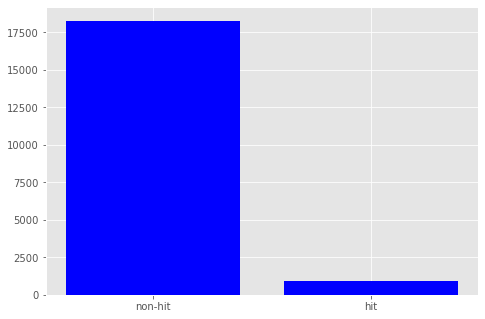

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
pop = ['non-hit', 'hit']
pop_count = list(df['hit'].value_counts())
ax.bar(pop,pop_count,color='b')
#plt.savefig('plot.png', dpi=200, bbox_inches='tight')

plt.show()

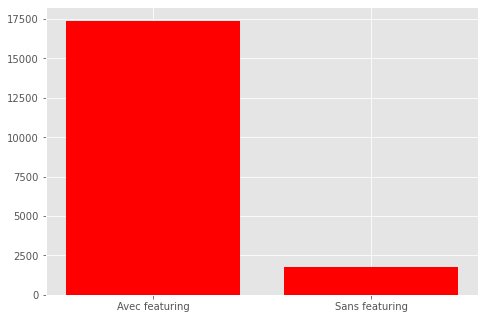

In [45]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
pop = ['Avec featuring', 'Sans featuring']
pop_count = list(df['featuring'].value_counts())
ax.bar(pop,pop_count,color='r')
plt.show()

In [5]:
# Filtrer df pour avoir seulement les musiques hits
df_pop_1=df.loc[df['hit']==1]

# Filtrer df pour avoir seulement les musiques non-hits
df_pop_0=df.loc[df['hit']==0]

print('les dimensions des musiques non-hits et hits sont respectivement {} et {}'.format(df_pop_0.shape,df_pop_1.shape))

les dimensions des musiques non-hits et hits sont respectivement (18280, 24) et (902, 24)


In [6]:
# Parmi les musiques hits, filter pour avoir seulement celles avec featuring
df_pop_1_feat_1 = df_pop_1.loc[df_pop_1['featuring']==1].shape

# Parmi les musiques hits, filter pour avoir seulement celles sans featuring
df_pop_1_feat_0 = df_pop_1.loc[df_pop_1['featuring']==0].shape

print('Parmi les musiques hits, les dimensions de celles qui sont avec featuring et sans featuring sont respectivement {} et {}'
      .format(df_pop_1_feat_1,df_pop_1_feat_0))

Parmi les musiques hits, les dimensions de celles qui sont avec featuring et sans featuring sont respectivement (142, 24) et (760, 24)


In [7]:
# Parmi les musiques non-hits, filter pour avoir seulement celles sans featuring
df_pop_0_feat_0 = df_pop_0.loc[df_pop_0['featuring']==0].shape

# Parmi les musiques non-hits, filter pour avoir seulement celles avec featuring
df_pop_0_feat_1 = df_pop_0.loc[df_pop_0['featuring']==1].shape

print('parmi les musiques non-hit, les dimensions de celles qui sont avec et sans featuring sont respectivement {} et {}'.format(df_pop_0_feat_1,df_pop_0_feat_0))

parmi les musiques non-hit, les dimensions de celles qui sont avec et sans featuring sont respectivement (1639, 24) et (16641, 24)


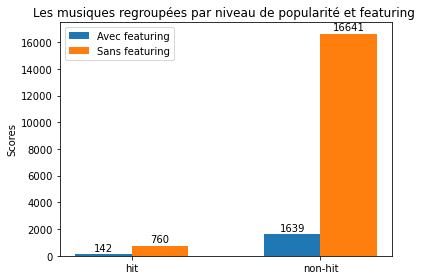

In [8]:
import numpy as np
labels = ['hit', 'non-hit']
# set height of bar
bar1=[df_pop_1_feat_1[0],df_pop_0_feat_1[0]]
bar2=[df_pop_1_feat_0[0],df_pop_0_feat_0[0]]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bar1, width, label='Avec featuring')
rects2 = ax.bar(x + width/2, bar2, width, label='Sans featuring')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Les musiques regroupées par niveau de popularité et featuring ')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

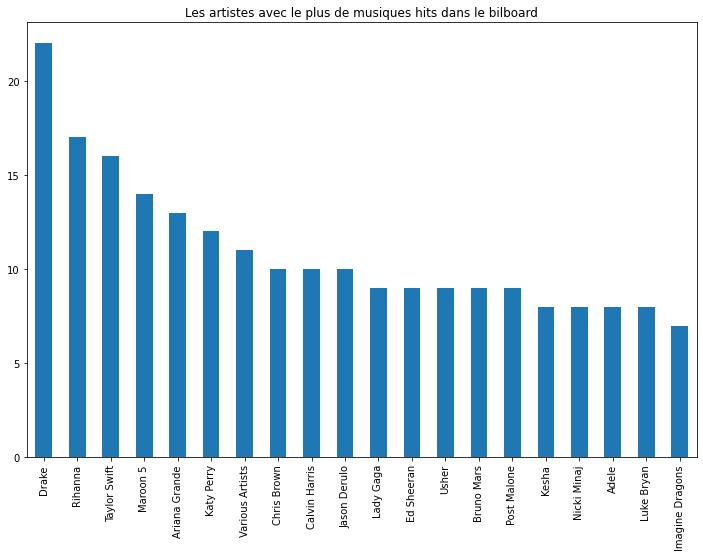

In [9]:
plt.figure(figsize=(12,8))
df[df['hit']==1]['nom_artiste'].value_counts()[:20].plot(kind="bar")
plt.title("Les artistes avec le plus de musiques hits dans le bilboard")
plt.show()

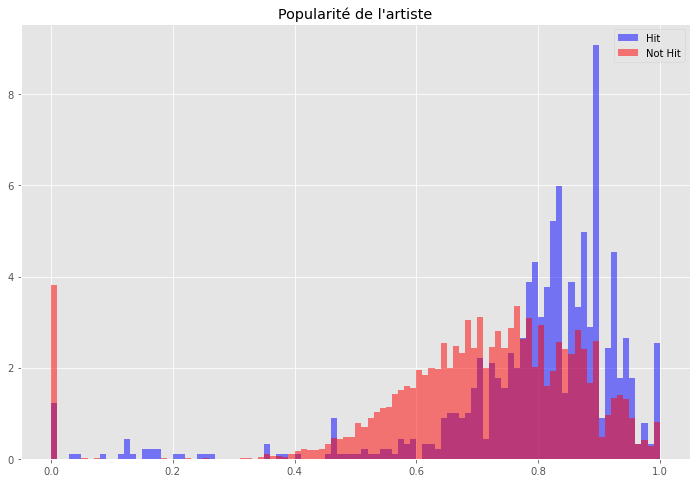

In [46]:
plt.figure(figsize=(12,8))
plt.hist(df[df['hit']==1]['pop_artiste'], bins=100, density=True, alpha=0.5, label="Hit",color='b')
plt.hist(df[df['hit']==0]['pop_artiste'], bins=100, density=True, alpha=0.5, label="Not Hit",color='r')
plt.title("Popularité de l'artiste")
plt.legend()
plt.show()

In [11]:
from scipy.stats import skew as sk
from scipy import stats

h=sk(df[df['hit']==1]['pop_artiste'])
n_h=sk(df[df['hit']==0]['pop_artiste'])

q_2_h=np.percentile(df[df['hit']==1]['pop_artiste'], 50)
q_3_n_h=np.percentile(df[df['hit']==0]['pop_artiste'], 75)
print('Les coefficients d"assymétrie de Fisher pour le distribution des musiques hits et non-hits ' 
      'sont respectivement {} et {}. La médiane de la distribution des musiques hits est de {}. '
      ' Le troisième quartile de la distribution des musiques non hits est de {} '.format(round(h,2),round(n_h,2),q_2_h,q_3_n_h))
#print("{},{}".format(h,n_h))

Les coefficients d"assymétrie de Fisher pour le distribution des musiques hits et non-hits sont respectivement -2.62 et -1.86. La médiane de la distribution des musiques hits est de 82.0.  Le troisième quartile de la distribution des musiques non hits est de 82.0 


In [12]:
features_hit = df.loc[df['hit']==1 ,['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite', 'eloquence', 'valence']]

features_non_hit = df.loc[df['hit']==0 ,['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite', 'eloquence', 'valence']]


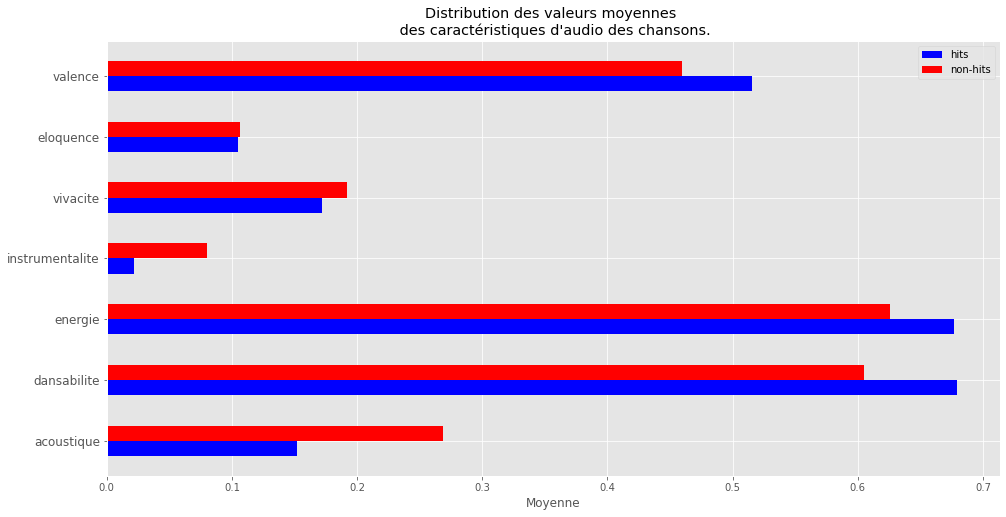

In [40]:
#%%capture
import numpy as np
from matplotlib import pyplot as plt

features_hit = df.loc[df['hit']==1 ,['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite', 'eloquence', 'valence']]

features_non_hit = df.loc[df['hit']==0 ,['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite', 'eloquence', 'valence']]

N = len(features_hit.mean())
#Liste des nombre de variables
ind = np.arange(N) 

width = 0.25  
#diagrame en batons avec la liste des musiques hits
plt.barh(ind, features_hit.mean() , width, label='hits', color = 'blue')
#diagrame en batons avec la liste des musiques non hits
plt.barh(ind + width, features_non_hit.mean(), width, label='non-hits', color = 'red')

#X- label
plt.xlabel('Moyenne', fontsize = 12)
# Title
plt.title("Distribution des valeurs moyennes \n des caractéristiques d'audio des chansons.")
#Vertical ticks
plt.yticks(ind + width / 2, (list(features_non_hit)[:]), fontsize = 12)
#legend
plt.legend(loc='best')
# Figure size
plt.rcParams['figure.figsize'] =(16,8)
# Set style
plt.style.use("ggplot")
plt.show()

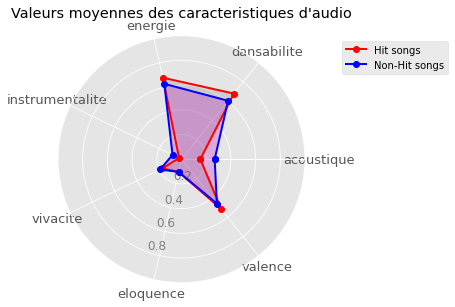

In [43]:
import seaborn as sns
labels= list(features_hit)
mean_list1= features_hit.mean().to_list()
mean_list2 = features_non_hit.mean().to_list()

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# close the plot
mean_list1=np.concatenate((mean_list1,[mean_list1[0]]))
mean_list2 =np.concatenate((mean_list2,[mean_list2[0]])) 
angles=np.concatenate((angles,[angles[0]]))

#Size of the figure
fig=plt.figure(figsize = (10,10))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, mean_list1, 'o-', linewidth=2, label = "Hit songs", color= 'r')
ax.fill(angles, mean_list1, alpha=0.25, facecolor='gray')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, mean_list2, 'o-', linewidth=2, label = "Non-Hit songs", color = 'b')
ax.fill(angles, mean_list2, alpha=0.25, facecolor='m')
ax.set_title("Valeurs moyennes des caracteristiques d'audio")
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(1.6, 1.0))
plt.style.use("ggplot")

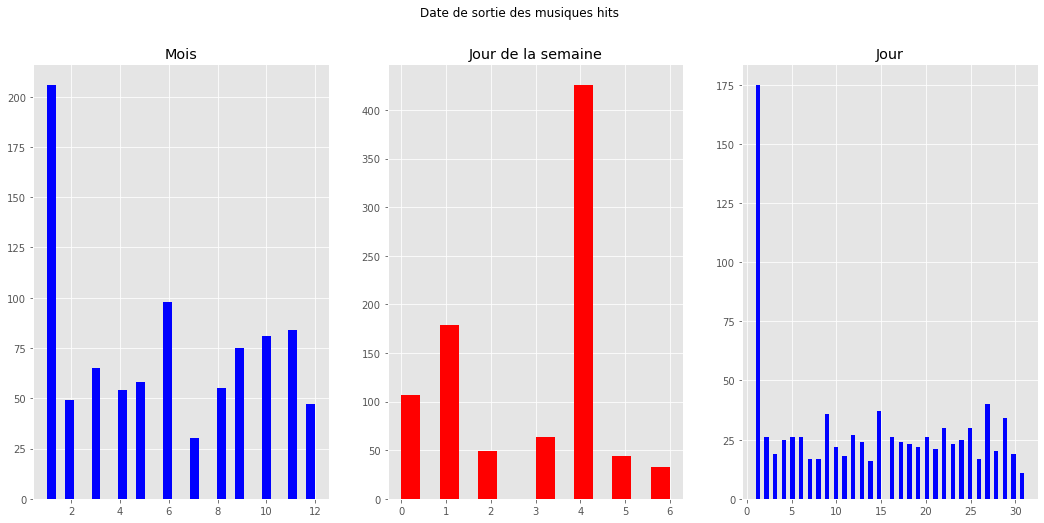

In [15]:
#%%capture
fig,(ax1, ax2, ax3)=plt.subplots(1,3,figsize=(18,8))
fig.suptitle('Date de sortie des musiques hits')
ax1.set_title('Mois')
ax1.hist(df[df['hit']==1]['mois_sortie'], bins=30, color='blue')
ax2.set_title('Jour de la semaine')
ax2.hist(df[df['hit']==1]['jour_sem_sortie'], bins=14,color='red')
ax3.set_title('Jour')
ax3.hist(df[df['hit']==1]['jour_sortie'], bins=62,color='blue')
plt.show()

# Modèle de machine learning

Jusque-là, nous avons pu découvrir quelques interéssants insights sur les données. Afin d'écourter cet article, passons directement en la partie concernant l'algorithme de machine learning que nous allons utiliser. Nous allons construire un modèle afin de prédire la classe, hit ou non-hit, qu'une musique est la plus susceptible d'appartenir en nous basant sur un ensemble de variables explicatives, comme expliqué au début.

In [15]:
#Suppression de variables qui ne sont pas utilisées par le modèle
df.drop(['nom_chanson','search','nom_artiste','date_sortie',
        'jour_sem_sortie','jour_sortie','mois_sortie','time_signature'],axis=1,inplace=True)

In [8]:
# Vérification de la corrélation entre les variables
df.corr()

,pop_artiste,tot_followers,marche_disp,pop_chanson,acoustique,dansabilite,duree,energie,instrumentalite,vivacite,intensite,eloquence,tempo,valence,hit,featuring
pop_artiste,1.000000,0.471912,-0.007970,0.303244,-0.112337,0.167648,0.003173,0.065691,-0.180871,-0.031044,0.167329,0.099747,0.044434,0.001326,0.100202,0.094110
tot_followers,0.471912,1.000000,-0.035460,0.225527,-0.060578,0.103486,0.021223,0.027303,-0.129870,0.002913,0.105655,0.078609,0.013359,-0.009974,0.176870,0.012169
marche_disp,-0.007970,-0.035460,1.000000,0.296946,0.072134,0.064373,-0.045037,-0.100037,0.043718,-0.010908,-0.085212,0.076791,-0.022189,-0.013525,-0.055483,0.061697
pop_chanson,0.303244,0.225527,0.296946,1.000000,0.034527,0.160340,-0.117822,-0.093330,-0.057530,-0.059950,-0.000687,0.058368,-0.028977,-0.019740,0.213542,0.084356
acoustique,-0.112337,-0.060578,0.072134,0.034527,1.000000,-0.198839,-0.034941,-0.685474,0.300345,-0.108809,-0.565409,-0.076829,-0.172492,-0.200237,-0.083301,-0.086256
dansabilite,0.167648,0.103486,0.064373,0.160340,-0.198839,1.000000,-0.156642,0.136154,-0.365995,-0.115685,0.365975,0.221945,0.011226,0.456078,0.089727,0.143945
duree,0.003173,0.021223,-0.045037,-0.117822,-0.034941,-0.156642,1.000000,0.022156,0.032031,0.033742,-0.017676,-0.044298,-0.018763,-0.149138,-0.004841,0.004279
energie,0.065691,0.027303,-0.100037,-0.093330,-0.685474,0.136154,0.022156,1.000000,-0.318399,0.189026,0.706722,0.075412,0.218443,0.375619,0.048462,0.049591
instrumentalite,-0.180871,-0.129870,0.043718,-0.057530,0.300345,-0.365995,0.032031,-0.318399,1.000000,0.034205,-0.629096,-0.134181,-0.152351,-0.290987,-0.053647,-0.090761
vivacite,-0.031044,0.002913,-0.010908,-0.059950,-0.108809,-0.115685,0.033742,0.189026,0.034205,1.000000,0.034256,0.114144,-0.007540,-0.007714,-0.027537,0.008407


Les niveaux de corrélation des variables quantitatives sont acceptables. Notre modèle pourra fonctionner très bien avec. 

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite','intensite','eloquence', 'valence','tempo','pop_artiste','tot_followers','marche_disp','duree','pop_chanson']]=scaler.fit_transform(df[['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite','intensite','eloquence', 'valence','tempo','pop_artiste','tot_followers','marche_disp','duree','pop_chanson']])

In [17]:
X=df[['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite','intensite','eloquence', 'valence','tempo','duree']]
y=df['hit']

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

# Oversampling training data
X_res, y_res = sm.fit_resample(X_train, y_train)

In [14]:
%%capture
# Optimisation des paramètre à choisir pour le modèle
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'auc', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(90,102,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid, scoring='accuracy')

gridsearch.fit(X_res, y_res,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)

In [15]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.2, 'n_estimators': 90}


In [19]:
%%capture
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Paramètres optimisés via GridSearch
clf = lgb.LGBMClassifier( boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=90, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0 )

clf.fit(X_train, y_train)

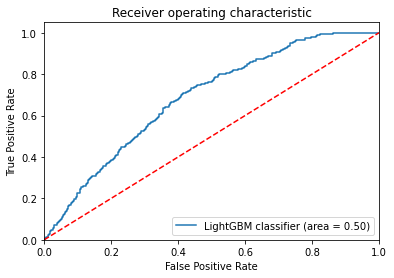

In [20]:
clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LightGBM classifier (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

In [21]:
#Matrice de confusion
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, clf.predict(X_test))
print('Matrice confusion \n\n', cm)
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[1,0])
print('\nFalse Negatives(FN) = ', cm[0,1])

Matrice confusion 

 [[5465   19]
 [ 268    3]]

True Positives(TP) =  3

True Negatives(TN) =  5465

False Positives(FP) =  268

False Negatives(FN) =  19


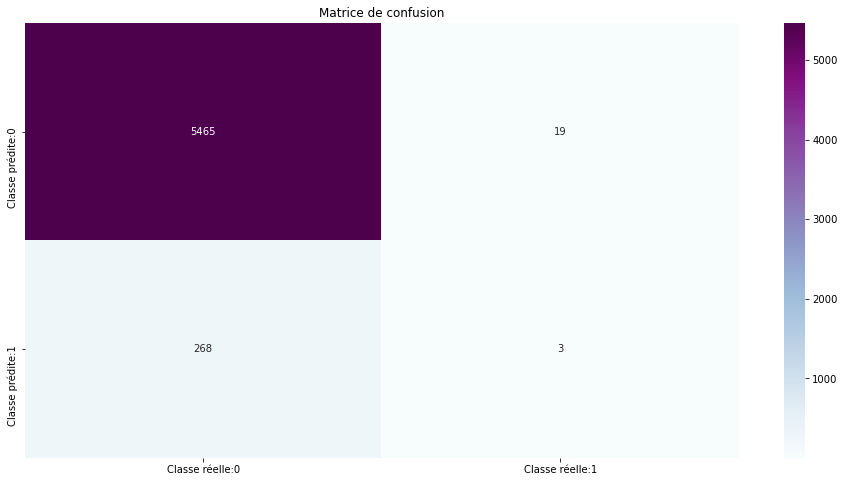

In [22]:
cm = confusion_matrix(y_test, clf.predict(X_test))
mc_matrice = pd.DataFrame(data=cm, columns=['Classe réelle:0', 'Classe réelle:1'], 
                                 index=['Classe prédite:0', 'Classe prédite:1'])
plt.figure(figsize=(16,8))
ax1=plt.axes()
sns.heatmap(mc_matrice, ax=ax1, annot=True, fmt='d', cmap='BuPu')
ax1.set_title('Matrice de confusion')

plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5484
           1       0.14      0.01      0.02       271

    accuracy                           0.95      5755
   macro avg       0.54      0.50      0.50      5755
weighted avg       0.91      0.95      0.93      5755



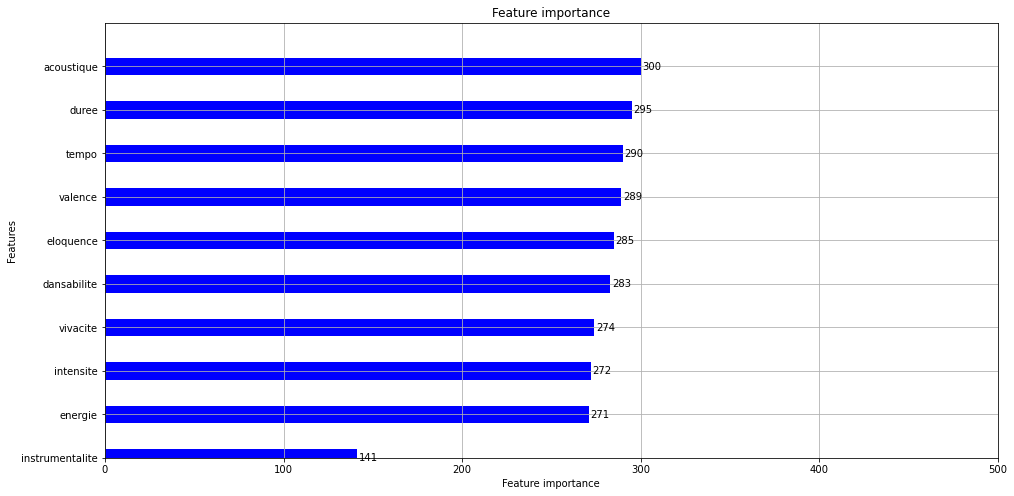

In [24]:
#plt.figure(figsize=(16,8))
ax=lgb.plot_importance(clf, height = 0.4,                  
                         max_num_features = 10, 
                         importance_type='split',
                         xlim = (0,500), ylim = (0,10),color='b', 
                         figsize = (16,8))


plt.show()

### Plus de données, meilleur modèle

In [25]:
X=df[['acoustique', 'dansabilite', 'energie', 'instrumentalite', 'vivacite','intensite','eloquence', 'valence','tempo','duree','featuring','pop_artiste','tot_followers','marche_disp','pop_chanson']]
y=df['hit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=20)

X_res, y_res = sm.fit_resample(X_train, y_train)

clf.fit(X_res, y_res)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=90, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

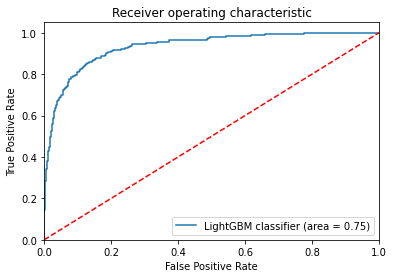

In [29]:
clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LightGBM classifier (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

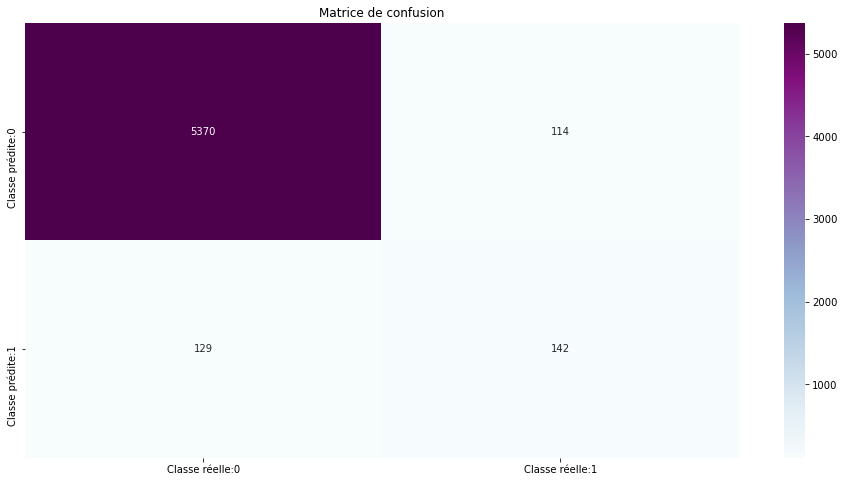

In [26]:
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
mc_matrice = pd.DataFrame(data=cm, columns=['Classe réelle:0', 'Classe réelle:1'], 
                                 index=['Classe prédite:0', 'Classe prédite:1'])
plt.figure(figsize=(16,8))
ax2=plt.axes()
sns.heatmap(mc_matrice, ax=ax2, annot=True, fmt='d', cmap='BuPu')
ax2.set_title('Matrice de confusion')
plt.show()

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['non-hit','hit']))

              precision    recall  f1-score   support

     non-hit       0.98      0.98      0.98      5484
         hit       0.55      0.52      0.54       271

    accuracy                           0.96      5755
   macro avg       0.77      0.75      0.76      5755
weighted avg       0.96      0.96      0.96      5755



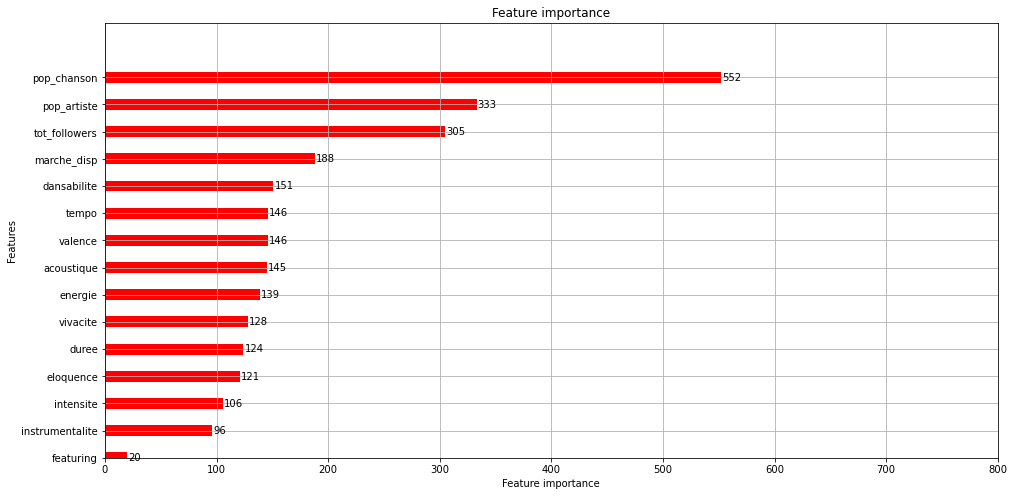

In [28]:
ax=lgb.plot_importance(clf, height = 0.4,                  
                         max_num_features = 18, 
                         importance_type='split',
                         xlim = (0,800), ylim = (0,16), color='r',
                         figsize = (16,8))
plt.show()

In [32]:
import joblib
# save model
joblib.dump(clf, 'song_classifier_part_1.pkl')

['song_classifier_part_1.pkl']

In [33]:
# load model
clf_pickle = joblib.load('song_classifier_part_1.pkl')